# Which Features to explain?
The objective of this notebook is to mechanically hand-pick features when show-casing the coefficients from the Lasso model. <br>
I'll be using LGBM as it can handle missing values by allocating them to side(during splits) that reduces loss. <br>
Therefore, the Data processing is a little different as I will change all the unknowns to np.nan. <br>

### Libraries to import:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from scipy import stats
%matplotlib inline
import random
pd.set_option('display.max_columns',500)
pd.set_option('display.max_rows',500)

### Import Data:
I have hand selected 79 columns from the original 240. <br>In addition, I will take a random sample of 750,000 for the sake of this project.

In [2]:
columns = ['dob_mm', 'dob_tt', 'dob_wk', 'bfacil', 'mager', 'mbstate_rec', 'restatus', 'mrace6', 'mhisp_r', 'mracehisp', 'dmar', 'meduc', 'fagecomb',
          'frace6', 'fhisp_r', 'fracehisp', 'feduc', 'priorlive', 'priordead', 'priorterm', 'illb_r', 'ilop_r', 'ilp_r', 'precare', 'previs', 'cig_0',
          'cig_1', 'cig_2', 'cig_3', 'm_ht_in', 'f_m_ht', 'bmi', 'pwgt_r', 'dwgt_r', 'wtgain', 'rf_pdiab', 'rf_gdiab', 'rf_phype', 'rf_ghype', 'rf_ehype',
          'rf_ppterm', 'rf_inftr', 'rf_fedrg', 'rf_artec', 'rf_cesar', 'rf_cesarn', 'no_risks', 'ip_gon', 'ip_syph', 'ip_chlam', 'ip_hepatb', 'ip_hepatc', 
          'no_infec', 'ob_ecvs', 'ob_ecvf', 'ld_indl', 'ld_augm', 'ld_ster', 'ld_antb', 'ld_chor', 'ld_anes', 'no_lbrdlv', 'me_pres', 'me_rout', 'me_trial',
          'rdmeth_rec', 'mm_mtr', 'mm_plac', 'mm_rupt', 'mm_uhyst', 'mm_aicu', 'no_mmorb', 'attend', 'mtran', 'pay', 'dplural', 'sex', 'combgest', 
#            'oegest_comb',
          'dbwt']

In [3]:
n = 3_801_534
s = 750_000
skip = sorted(random.sample(range(1, n + 1), n-s))

In [4]:
df = pd.read_csv('natl2018.csv.zip', low_memory=False, usecols=columns, skiprows=skip)
# df = df.sample(n=250_000, random_state=42)
df.shape

(750000, 79)

In [5]:
df.head()

,dob_mm,dob_tt,dob_wk,bfacil,mager,mbstate_rec,restatus,mrace6,mhisp_r,mracehisp,dmar,meduc,fagecomb,frace6,fhisp_r,fracehisp,feduc,priorlive,priordead,priorterm,illb_r,ilop_r,ilp_r,precare,previs,cig_0,cig_1,cig_2,cig_3,m_ht_in,f_m_ht,bmi,pwgt_r,dwgt_r,wtgain,rf_pdiab,rf_gdiab,rf_phype,rf_ghype,rf_ehype,rf_ppterm,rf_inftr,rf_fedrg,rf_artec,rf_cesar,rf_cesarn,no_risks,ip_gon,ip_syph,ip_chlam,ip_hepatb,ip_hepatc,no_infec,ob_ecvs,ob_ecvf,ld_indl,ld_augm,ld_ster,ld_antb,ld_chor,ld_anes,no_lbrdlv,me_pres,me_rout,me_trial,rdmeth_rec,mm_mtr,mm_plac,mm_rupt,mm_uhyst,mm_aicu,no_mmorb,attend,mtran,pay,dplural,sex,combgest,dbwt
0,1,1227,2,1,30,1,2,10,0,1,1.0,6,31,1,1,7,3,1,0,2,16,33,16,3,8,0,0,0,0,66,1,30.7,190,231,41,N,N,N,N,N,N,N,X,X,N,0,1,N,N,N,N,N,1,N,N,N,N,N,Y,N,Y,0,1,1,X,1,N,N,N,N,N,1,1,N,2,1,M,38,3657
1,1,336,2,1,28,1,1,10,0,1,1.0,6,31,1,0,1,4,1,0,0,999,888,999,5,17,0,0,0,0,71,1,30.0,215,273,58,N,N,Y,N,N,N,N,X,X,N,0,0,N,N,N,N,N,1,N,N,N,N,N,N,N,N,1,1,1,X,1,N,N,N,N,N,1,1,N,5,1,M,37,3470
2,1,1615,4,1,31,1,1,10,0,1,1.0,3,29,1,0,1,7,0,0,0,888,888,888,3,18,0,0,0,0,67,1,28.2,180,209,29,N,N,N,N,N,N,N,X,X,N,0,1,N,N,N,N,N,1,N,N,N,Y,N,N,N,Y,0,1,4,Y,3,N,N,N,N,N,1,1,N,2,1,F,40,3230
3,1,841,4,1,30,2,1,10,0,1,1.0,5,31,1,0,1,4,1,0,0,37,888,37,3,10,0,0,0,0,58,1,31.3,150,180,30,N,N,N,N,N,N,N,X,X,Y,1,0,N,N,N,N,N,1,N,N,N,N,N,N,N,Y,0,1,4,N,4,N,N,N,N,N,1,1,N,5,1,F,39,3810
4,1,1626,1,1,21,1,1,41,0,4,2.0,2,22,4,0,4,3,0,0,0,888,888,888,3,10,0,0,0,0,62,1,25.2,138,161,23,N,N,N,N,N,N,N,X,X,N,0,1,N,N,N,N,N,1,N,N,N,N,N,N,N,N,1,1,1,X,1,N,N,N,N,N,1,1,N,1,1,M,39,3635


In [6]:
def data_cleaning_births(_df):
    """
    Preprocessing columns by translating using column dictionary.
    The order of columns follows the same order as column dictionary.
    """
    
    # Birth Month, leave numbers as is; 12 = December, 01 = January
    _df['dob_mm'] = _df['dob_mm'] 
    
    
    # Time of Birth, dropping unknown
    _df['dob_tt'] = np.where(_df['dob_tt'].eq(9999), np.nan, _df['dob_tt'])
#     _df.drop(df[df['dob_tt'].eq(9999)].index, inplace=True)    
    
    
    # Birth Day of Week, leave as is; 7 = Saturday, 1 = Sunday
    _df['dob_wk'] = _df['dob_wk']
    
    # Birth Place; Home(intended) = Home(not intended)
    _df['bfacil'] = np.where(_df['bfacil'].eq(9), np.nan, _df['bfacil'])
    
    
    
    # Mother's Single Years of Age; note 0 = 10-12, and 50 = 50 and over
    _df['mager'] = _df['mager']
    
    # Mother's Nativity
    _df['mbstate_rec'] = np.where(_df['mbstate_rec'].eq(3), np.nan, _df['mbstate_rec'])
    
    
    # Residence Status
    _df['restatus'] = _df['restatus']

    
    # Mother's Race Recode 6
    _df['mrace6'] = _df['mrace6']
    
    # Mother's Hispanic Origin
    _df['mhisp_r'] = np.where(_df['mhisp_r'].eq(9), np.nan, _df['mhisp_r'])
    
    # Mother's Race/Hispanic Origin
    _df['mracehisp'] = np.where(_df['mracehisp'].eq(8), np.nan, _df['mracehisp'])
    
    
    # Marital Status
    _df['dmar'] = _df['dmar']
    
    # Mother's Education
    _df['meduc'] = np.where(_df['meduc'].eq(9), np.nan, _df['meduc'])
    
    # Father's combined Age: imputing missing fathers age with average
    _df['fagecomb'] = np.where(_df['fagecomb'].eq(99), np.nan, _df['fagecomb'])
    
    # Father's Race recode
    _df['frace6'] = np.where(_df['frace6'].eq(9), np.nan, _df['frace6'])
    
    # Father's Hispanic Origin
    _df['fhisp_r'] = np.where(_df['fhisp_r'].eq(9), np.nan, _df['fhisp_r'])
    
    # Father's Race/Hispanic Origin
    _df['fracehisp'] = np.where(_df['fracehisp'].eq(9), np.nan, _df['fracehisp'])
    
    # Father's Education
    _df['feduc'] = np.where(_df['feduc'].eq(9), np.nan, _df['feduc'])
    
    # Prior Births Now Living
    _df['priorlive'] = np.where(_df['priorlive'].eq(99), np.nan, _df['priorlive'])
    
    # Prior Births Now Dead
    _df['priordead'] = np.where(_df['priordead'].eq(99), np.nan, _df['priordead'])
    
    # Prior Other Terminations
    _df['priorterm'] = np.where(_df['priorterm'].eq(99), np.nan, _df['priorterm'])
    
    
    # Interval Since Last Live Birth Recode
    _df['illb_r'] = np.where(_df['illb_r'].eq(999), np.nan, _df['illb_r'])
    _df['illb_r'] = np.where(_df['illb_r'].eq(888), 0, _df['illb_r'])
    
    # Interval since last other Pregnancy
    _df['ilop_r'] = np.where(_df['ilop_r'].eq(999), np.nan, _df['ilop_r'])
    _df['ilop_r'] = np.where(_df['ilop_r'].eq(888), 0, _df['ilop_r'])
    
    # Interval since Last pregnancy
    _df['ilp_r'] = np.where(_df['ilp_r'].eq(999), np.nan, _df['ilp_r'])    
    _df['ilp_r'] = np.where(_df['ilp_r'].eq(888), 0, _df['ilp_r'])
    
    # Month Prenatal Care Began
    _df['precare'] = np.where(_df['precare'].eq(99), np.nan, _df['precare'])
    
    # Number of Prenatal Visits
    _df['previs'] = np.where(_df['previs'].eq(99), np.nan, _df['previs'])
    
    # Cigarettes before Pregnancy
    _df['cig_0'] = np.where(_df['cig_0'].eq(99), np.nan, _df['cig_0'])
    
    # Cigarettes 1st Trimester
    _df['cig_1'] = np.where(_df['cig_1'].eq(99), np.nan, _df['cig_1'])
    
    # Cigarettes 2nd Trimester
    _df['cig_2'] = np.where(_df['cig_2'].eq(99), np.nan, _df['cig_2'])
    
    # Cigarettes 3rd Trimester
    _df['cig_3'] = np.where(_df['cig_3'].eq(99), np.nan, _df['cig_3'])
    
    
    # Mother's Height in Total Inches: imputing average height if missing
    _df['m_ht_in'] = np.where(_df['m_ht_in'].eq(99), np.nan, _df['m_ht_in'])
    
    # Height Reported
    _df['f_m_ht'] = _df['f_m_ht']
    
    
    # Body Mass Index: if missing, impute mean
    _df['bmi'] = np.where(_df['bmi'].eq(99), np.nan, _df['bmi'])
    
    # Pre-pregnancy weight
    _df['pwgt_r'] = np.where(_df['pwgt_r'].eq(999), np.nan, _df['pwgt_r'])
    
    
    # Delivery Weight Recode
    _df['dwgt_r'] = np.where(_df['dwgt_r'].eq(999), np.nan, _df['dwgt_r'])
    
    
    # Weight Gain
    _df['wtgain'] = np.where(_df['wtgain'].eq(99), np.nan , _df['wtgain'])
    
    # Pre-pregnancy Diabetes
    conditions = [
        _df['rf_pdiab'].eq('Y'),
        _df['rf_pdiab'].eq('N'),
    ]
    choices = [
        1,
        0
    ]
    _df['rf_pdiab'] = np.select(conditions, choices, np.nan)
    
    # Gestational Diabetes
    conditions = [
        _df['rf_gdiab'].eq('Y'),
        _df['rf_gdiab'].eq('N'),
    ]
    choices = [
        1,
        0
    ]
    _df['rf_gdiab'] = np.select(conditions, choices, np.nan)
    
    
    # Pre-pregnancy Hypertension
    conditions = [
        _df['rf_phype'].eq('Y'),
        _df['rf_phype'].eq('N'),
    ]
    choices = [
        1,
        0
    ]
    _df['rf_phype'] = np.select(conditions, choices, np.nan)
    
    # Gestational Hypertension
    conditions = [
        _df['rf_ghype'].eq('Y'),
        _df['rf_ghype'].eq('N'),
    ]
    choices = [
        1,
        0
    ]
    _df['rf_ghype'] = np.select(conditions, choices, np.nan)
    
    # Hypertension Eclampsia
    conditions = [
        _df['rf_ehype'].eq('Y'),
        _df['rf_ehype'].eq('N'),
    ]
    choices = [
        1,
        0
    ]
    _df['rf_ehype'] = np.select(conditions, choices, np.nan)
    
    
    # Previous Preterm Birth
    conditions = [
        _df['rf_ppterm'].eq('Y'),
        _df['rf_ppterm'].eq('N'),
    ]
    choices = [
        1,
        0
    ]
    _df['rf_ppterm'] = np.select(conditions, choices, np.nan)
    
    
    # Infertility Treatment Used
    conditions = [
        _df['rf_inftr'].eq('Y'),
        _df['rf_inftr'].eq('N'),
    ]
    choices = [
        1,
        0
    ]
    _df['rf_inftr'] = np.select(conditions, choices, np.nan)
    
    
    # Fertility Enhancing Drugs
    conditions = [
        _df['rf_fedrg'].eq('Y'),
        _df['rf_fedrg'].eq('N'),
        _df['rf_fedrg'].eq('X')
    ]
    choices = [
        1,
        0,
        2
    ]
    _df['rf_fedrg'] = np.select(conditions, choices, np.nan)
    
    # Reproductive Technology
    conditions = [
        _df['rf_artec'].eq('Y'),
        _df['rf_artec'].eq('N'),
        _df['rf_artec'].eq('X')
    ]
    choices = [
        1,
        0,
        2
    ]
    _df['rf_artec'] = np.select(conditions, choices, np.nan)
    
    # Previous Cesarean
    conditions = [
        _df['rf_cesar'].eq('Y'),
        _df['rf_cesar'].eq('N'),
    ]
    choices = [
        1,
        0
    ]
    _df['rf_cesar'] = np.select(conditions, choices, np.nan)
    
    

    
    # Number of Previous Cesareans
    _df['rf_cesarn'] = np.where(_df['rf_cesarn'].eq(99), np.nan, _df['rf_cesarn'])
    
    
    # No Risk Factors Reported
    _df['no_risks'] = np.where(_df['no_risks'].eq(9), np.nan, _df['no_risks'])
    
    # IP_GON Gonorrhea
    conditions = [
        _df['ip_gon'].eq('Y'),
        _df['ip_gon'].eq('N')
    ]
    choices = [
        1,
        0
    ]
    _df['ip_gon'] = np.select(conditions, choices, np.nan)
    
    # Syphilis
    conditions = [
        _df['ip_syph'].eq('Y'),
        _df['ip_syph'].eq('N')
    ]
    choices = [
        1,
        0
    ]
    _df['ip_syph'] = np.select(conditions, choices, np.nan)
    
    # Chlamydia
    conditions = [
        _df['ip_chlam'].eq('Y'),
        _df['ip_chlam'].eq('N')
    ]
    choices = [
        1,
        0
    ]
    _df['ip_chlam'] = np.select(conditions, choices, np.nan)
    
    # Hepatitis B
    conditions = [
        _df['ip_hepatb'].eq('Y'),
        _df['ip_hepatb'].eq('N')
    ]
    choices = [
        1,
        0
    ]
    _df['ip_hepatb'] = np.select(conditions, choices, np.nan)
    
    # Hepatitis C
    conditions = [
        _df['ip_hepatc'].eq('Y'),
        _df['ip_hepatc'].eq('N')
    ]
    choices = [
        1,
        0
    ]
    _df['ip_hepatc'] = np.select(conditions, choices, np.nan)
    

    
    # No Infections Reported
    _df['no_infec'] = np.where(_df['no_infec'].eq(9), np.nan, _df['no_infec'])
    
    # OB_ECVS Successful External Cephalic Version
    conditions = [
        _df['ob_ecvs'].eq('Y'),
        _df['ob_ecvs'].eq('N')
    ]
    choices = [
        1,
        0
    ]
    _df['ob_ecvs'] = np.select(conditions, choices, np.nan)
    
    # Failed External Cephalic Version
    conditions = [
        _df['ob_ecvf'].eq('Y'),
        _df['ob_ecvf'].eq('N')
    ]
    choices = [
        1,
        0
    ]
    _df['ob_ecvf'] = np.select(conditions, choices, np.nan)
    
    # Induction of Labor
    conditions = [
        _df['ld_indl'].eq('Y'),
        _df['ld_indl'].eq('N')
    ]
    choices = [
        1,
        0
    ]
    _df['ld_indl'] = np.select(conditions, choices, np.nan)
    
    # Augmentation of Labor
    conditions = [
        _df['ld_augm'].eq('Y'),
        _df['ld_augm'].eq('N')
    ]
    choices = [
        1,
        0
    ]
    _df['ld_augm'] = np.select(conditions, choices, np.nan)
    
    # Steroids
    conditions = [
        _df['ld_ster'].eq('Y'),
        _df['ld_ster'].eq('N')
    ]
    choices = [
        1,
        0
    ]
    _df['ld_ster'] = np.select(conditions, choices, np.nan)
    
    # Antibiotics
    conditions = [
        _df['ld_antb'].eq('Y'),
        _df['ld_antb'].eq('N')
    ]
    choices = [
        1,
        0
    ]
    _df['ld_antb'] = np.select(conditions, choices, np.nan)
    
    
    # Chorioamionitis
    conditions = [
        _df['ld_chor'].eq('Y'),
        _df['ld_chor'].eq('N')
    ]
    choices = [
        1,
        0
    ]
    _df['ld_chor'] = np.select(conditions, choices, np.nan)
    
    # Anesthesia
    conditions = [
        _df['ld_anes'].eq('Y'),
        _df['ld_anes'].eq('N')
    ]
    choices = [
        1,
        0
    ]
    _df['ld_anes'] = np.select(conditions, choices, np.nan)
    

    
    # No Characteristics of Labor Reported
    _df['no_lbrdlv'] = np.where(_df['no_lbrdlv'].eq(9), np.nan, _df['no_lbrdlv'])
    
    
    # Fetal Presentation at Delivery
    _df['me_pres'] = np.where(_df['me_pres'].eq(9), np.nan, _df['me_pres'])
    
    
    # Final Route and Method of Delivery
    _df['me_rout'] = np.where(_df['me_rout'].eq(9), np.nan, _df['me_rout'])
    
    # Trial of Labor Attempted
    conditions = [
        _df['me_trial'].eq('Y'),
        _df['me_trial'].eq('N'),
        _df['me_trial'].eq('X')
    ]
    choices = [
        1,
        0,
        2
    ]
    _df['me_trial'] = np.select(conditions, choices, np.nan)
    
    # Delivery Method Recode
    _df['rdmeth_rec'] = np.where(_df['rdmeth_rec'].eq(9), np.nan, _df['rdmeth_rec'])
    
    # Maternal Transfusion
    conditions = [
        _df['mm_mtr'].eq('Y'),
        _df['mm_mtr'].eq('N')
    ]
    choices = [
        1,
        0
    ]
    _df['mm_mtr'] = np.select(conditions, choices, np.nan)
    
    # Perineal Laceration
    conditions = [
        _df['mm_plac'].eq('Y'),
        _df['mm_plac'].eq('N')
    ]
    choices = [
        1,
        0
    ]
    _df['mm_plac'] = np.select(conditions, choices, np.nan)
    
    # Ruptured Uterus
    conditions = [
        _df['mm_rupt'].eq('Y'),
        _df['mm_rupt'].eq('N')
    ]
    choices = [
        1,
        0
    ]
    _df['mm_rupt'] = np.select(conditions, choices, np.nan)
    
    
    # Unplanned Hysterectomy
    conditions = [
        _df['mm_uhyst'].eq('Y'),
        _df['mm_uhyst'].eq('N')
    ]
    choices = [
        1,
        0
    ]
    _df['mm_uhyst'] = np.select(conditions, choices, np.nan)
    
    
    # Admit to Intensive Care
    conditions = [
        _df['mm_aicu'].eq('Y'),
        _df['mm_aicu'].eq('N')
    ]
    choices = [
        1,
        0
    ]
    _df['mm_aicu'] = np.select(conditions, choices, np.nan)
    
    

    
    # No Maternal Morbidty Reported
    _df['no_mmorb'] = np.where(_df['no_mmorb'].eq(9), np.nan, _df['no_mmorb'])
    
    # Attendant at Birth
    _df['attend'] = np.where(_df['attend'].eq(9), np.nan, _df['attend'])
    
    
    # Mother Transferred
    conditions = [
        _df['mtran'].eq('Y'),
        _df['mtran'].eq('N')
    ]
    choices = [
        1,
        0
    ]
    _df['mtran'] = np.select(conditions, choices, np.nan)
    
    # Payment Source for Delivery
    _df['pay'] = np.where(_df['pay'].eq(9), np.nan, _df['pay'])
    
    
    # Plurality Recode
    # skip
    
    # Sex of Infant
    _df['sex'] = np.where(_df['sex'].eq('M'), 1, 0)
    
    # Combined Gestation
    _df['combgest'] = np.where(_df['combgest'].eq(99), np.nan, _df['combgest'])
    
    # Obstetric Estimate
#     _df['oegest_comb'] = np.where(_df['oegest_comb'].eq(99), np.nan, _df['oegest_comb'])
    
    # Birth Weight
    _df.drop(df[df['dbwt'].eq(9999)].index, inplace=True)
    
    
    return _df

In [7]:
df = data_cleaning_births(df)

In [8]:
df.isna().sum()

dob_mm              0
dob_tt             38
dob_wk              0
bfacil             47
mager               0
mbstate_rec      1570
restatus            0
mrace6              0
mhisp_r          6652
mracehisp        6652
dmar            89938
meduc            9536
fagecomb        87034
frace6         135657
fhisp_r         95755
fracehisp        5317
feduc          102971
priorlive        1381
priordead        1875
priorterm        2351
illb_r          23761
ilop_r          73955
ilp_r           89528
precare         18687
previs          18675
cig_0            3610
cig_1            3458
cig_2            3501
cig_3            7265
m_ht_in          3741
f_m_ht              0
bmi                 0
pwgt_r          14895
dwgt_r          10922
wtgain          22893
rf_pdiab          484
rf_gdiab          484
rf_phype          484
rf_ghype          484
rf_ehype          484
rf_ppterm         484
rf_inftr          484
rf_fedrg         1435
rf_artec         1435
rf_cesar          484
rf_cesarn 

# Model Evaluation
The final model will be a linear regression with l1 regularization(for feature selection). <br>
In order to be concise on interpretation, I will pick the features most important from a decision tree model. <br>


Talk about the Top 10 features from Linear Regression. <br>
I will use Root Mean Squared Error(RMSE) as the metric when evaluating on the test set.
The data has many missing values and I will impute using two different methods:
1. KNNImpute
2. LGBM
3. Impute Majority Class



In [9]:
X = df.drop(columns=['dbwt'])
y = df['dbwt']

In [10]:
# X.drop(columns = ['oegest_comb'], inplace=True)

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

In [13]:
X_train

,dob_mm,dob_tt,dob_wk,bfacil,mager,mbstate_rec,restatus,mrace6,mhisp_r,mracehisp,dmar,meduc,fagecomb,frace6,fhisp_r,fracehisp,feduc,priorlive,priordead,priorterm,illb_r,ilop_r,ilp_r,precare,previs,cig_0,cig_1,cig_2,cig_3,m_ht_in,f_m_ht,bmi,pwgt_r,dwgt_r,wtgain,rf_pdiab,rf_gdiab,rf_phype,rf_ghype,rf_ehype,rf_ppterm,rf_inftr,rf_fedrg,rf_artec,rf_cesar,rf_cesarn,no_risks,ip_gon,ip_syph,ip_chlam,ip_hepatb,ip_hepatc,no_infec,ob_ecvs,ob_ecvf,ld_indl,ld_augm,ld_ster,ld_antb,ld_chor,ld_anes,no_lbrdlv,me_pres,me_rout,me_trial,rdmeth_rec,mm_mtr,mm_plac,mm_rupt,mm_uhyst,mm_aicu,no_mmorb,attend,mtran,pay,dplural,sex,combgest
549031,10,1109.0,7,1.0,26,1.0,1,20,0.0,2.0,2.0,3.0,27.0,2.0,0.0,2.0,2.0,3.0,0.0,2.0,NaN,28.0,NaN,2.0,13.0,0.0,0.0,0.0,0.0,62.0,1,29.3,160.0,175.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,1.0,1,0,41.0
267490,4,1719.0,5,1.0,23,1.0,2,10,0.0,1.0,2.0,6.0,24.0,1.0,0.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,16.0,0.0,0.0,0.0,0.0,60.0,1,39.1,200.0,239.0,39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,4.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,1,0,39.0
99796,8,1045.0,7,5.0,35,1.0,1,41,0.0,4.0,NaN,6.0,44.0,1.0,0.0,1.0,7.0,1.0,0.0,0.0,45.0,0.0,45.0,2.0,14.0,0.0,0.0,0.0,0.0,66.0,1,18.7,116.0,151.0,35.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,3.0,1,0,39.0
502920,9,938.0,1,1.0,24,1.0,2,10,1.0,7.0,2.0,3.0,24.0,1.0,5.0,7.0,3.0,1.0,0.0,0.0,20.0,0.0,20.0,3.0,11.0,6.0,0.0,0.0,0.0,67.0,1,37.6,240.0,269.0,29.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,0.0,1.0,1,0,38.0
739578,7,1401.0,4,1.0,29,1.0,1,10,5.0,7.0,2.0,4.0,26.0,1.0,0.0,1.0,4.0,1.0,0.0,0.0,80.0,0.0,80.0,4.0,9.0,0.0,0.0,0.0,0.0,67.0,1,21.6,138.0,172.0,34.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,4.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1,1,38.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259271,11,1654.0,2,1.0,21,1.0,1,10,1.0,7.0,1.0,3.0,26.0,1.0,1.0,7.0,4.0,0.0,0.0,1.0,0.0,13.0,13.0,6.0,9.0,0.0,0.0,0.0,0.0,65.0,1,35.6,214.0,240.0,26.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,1,1,34.0
366021,6,146.0,7,1.0,33,1.0,1,10,0.0,1.0,2.0,5.0,55.0,1.0,0.0,1.0,4.0,2.0,0.0,2.0,90.0,NaN,NaN,3.0,12.0,10.0,0.0,0.0,0.0,68.0,1,28.1,185.0,193.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,8.0,1,0,39.0
131966,6,947.0,1,1.0,30,1.0,2,10,0.0,1.0,1.0,4.0,32.0,1.0,0.0,1.0,7.0,1.0,0.0,1.0,25.0,10.0,10.0,3.0,8.0,0.0,0.0,0.0,0.0,65.0,1,28.8,173.0,204.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,1,1,39.0
671698,11,1606.0,7,1.0,37,1.0,1,10,0.0,1.0,1.0,6.0,38.0,1.0,0.0,1.0,7.0,4.0,0.0,1.0,46.0,NaN,NaN,2.0,6.0,0.0,0.0,0.0,NaN,66.0,1,22.1,137.0,130.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,1,1,25.0


### Dummy Regressor

In [14]:
from sklearn.dummy import DummyRegressor

dummy_regr = DummyRegressor(strategy='mean')
dummy_regr.fit(X_train, y_train)

DummyRegressor(constant=None, quantile=None, strategy='mean')

In [15]:
dummy_regr.predict(X_test)

array([3260.83634847, 3260.83634847, 3260.83634847, ..., 3260.83634847,
       3260.83634847, 3260.83634847])

In [16]:
dummy_regr.score(X_test, y_test)

-5.619192724459765e-07

In [17]:
from sklearn.metrics import mean_squared_error

In [18]:
dummy_regr_rmse = np.sqrt(mean_squared_error(y_test, dummy_regr.predict(X_test)))
print('RMSE of Dummy Regressor(mean): ', dummy_regr_rmse)

RMSE of Dummy Regressor(mean):  588.7579841594858


### LGBM
I am going to hypertune a boosted decision tree with LGBM. I will then plot feature importance based off the splits. The top 20 features will be showcased for explanation on the linear regression model.

In [19]:
import lightgbm as lgb

In [20]:
X_lgbm_train, X_lgbm_valid, y_lgbm_train, y_lgbm_valid = train_test_split(X_train, y_train, random_state =42, test_size=0.2)

In [21]:
continuous_columns = ['dob_tt', 'mager', 'fagecomb', 'illb_r', 'ilop_r', 'ilp_r', 'precare', 'previs', 'm_ht_in', 'bmi', 'pwgt_r','dwgt_r', 'wtgain', 'dplural', 'combgest', 
#                       'oegest_comb'
                     ]
categorical_columns = [x for x in X.columns if x not in continuous_columns]

In [22]:
train_data = lgb.Dataset(X_lgbm_train, label = y_lgbm_train, categorical_feature=categorical_columns, free_raw_data=False)
y_valid_data = lgb.Dataset(X_lgbm_valid, label = y_lgbm_valid, categorical_feature=categorical_columns, free_raw_data=False)

In [23]:
import optuna
def objective(trial):
    params = {
        'objective': 'regression',
        'boosting': 'gbdt',
        'max_depth': trial.suggest_int('max_depth', 12, 56),
        'num_leaves': trial.suggest_int('num_leaves', 36, 98),
        'metric' :'rmse',

        'learning_rate' : 0.05,


        'bagging_fraction' : trial.suggest_loguniform('bag_frac', 0.5, 0.9),
        'feature_fraction': trial.suggest_loguniform('feat_frac', 0.5, 0.9),
        'lambda_l1' : trial.suggest_loguniform('l1', 0.1, 0.9),
        'lambda_l2' : trial.suggest_loguniform('l2', 0.1, 0.9),

        'verbosity': 1}


    m_lgb = lgb.train(params, train_data,num_boost_round=20000, valid_sets = y_valid_data, verbose_eval=100, early_stopping_rounds=500)
    _lgb_test_pred = m_lgb.predict(X_test)
    
    return np.sqrt(mean_squared_error(y_test, _lgb_test_pred))

In [ ]:
# 100 trials: this can take a while, feel free to interrupt at any time
# study = optuna.create_study()
# study.optimize(objective, n_trials=100)

In [25]:


params = {
    'objective': 'regression',
    'boosting': 'gbdt',
    'max_depth': 4,
    'num_leaves': 52,
    'metric' :'rmse',
    'learning_rate' : 0.05,

    'bagging_fraction' : 0.8,
    'feature_fraction': 0.7,
    'lambda_l1' : 0.2,
    'lambda_l2' : 0.2,
    'verbosity': 1

}

#{'max_depth': 34, 'num_leaves': 76, 'bag_frac': 0.8759571822016871, 'feat_frac': 0.7223930318441374, 'l1': 0.32325233156783945, 'l2': 0.6165022128007611}
#{'max_depth': 17, 'num_leaves': 52, 'bag_frac': 0.8688273105209472, 'feat_frac': 0.52605500925574, 'l1': 0.12165014355405701, 'l2': 0.3940475859199809}

In [26]:
m_lgb = lgb.train(params, train_data,num_boost_round=1000, valid_sets = y_valid_data, verbose_eval=100)

[100]	valid_0's rmse: 422.295
[200]	valid_0's rmse: 416.228
[300]	valid_0's rmse: 414.093
[400]	valid_0's rmse: 413.012
[500]	valid_0's rmse: 412.198
[600]	valid_0's rmse: 411.689
[700]	valid_0's rmse: 411.302
[800]	valid_0's rmse: 410.997
[900]	valid_0's rmse: 410.833
[1000]	valid_0's rmse: 410.636


In [27]:
_lgb_test_pred = m_lgb.predict(X_test)
np.sqrt(mean_squared_error(y_test, _lgb_test_pred))

407.6625664202261

In [28]:
from sklearn.metrics import r2_score

In [29]:
r2_score(y_test, _lgb_test_pred)

0.5205665921975512

In [32]:
import shap

In [33]:
explainer = shap.TreeExplainer(m_lgb)
shap_values = explainer.shap_values(X)

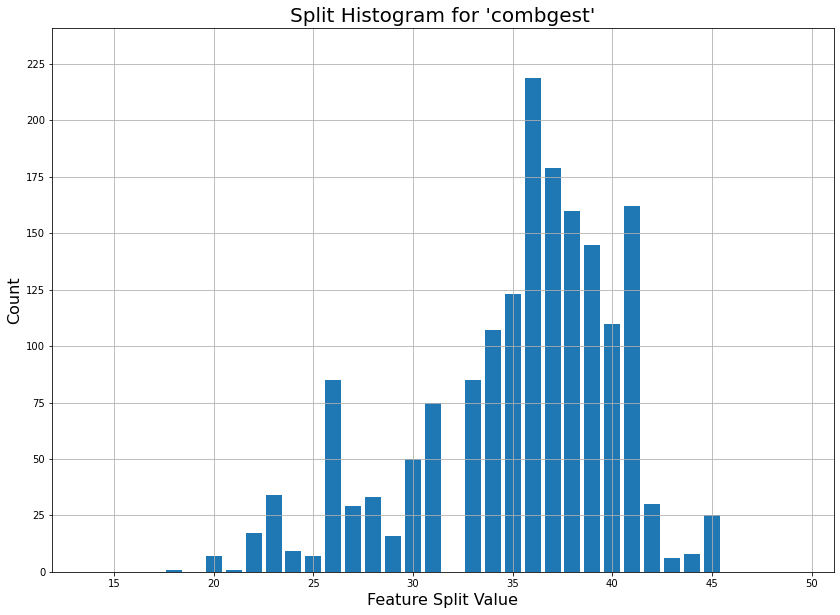

In [91]:
fig, ax = plt.subplots(figsize=(14,10))
lgb.plot_split_value_histogram(m_lgb, feature='combgest', ax= ax)
ax.set_title('Split Histogram for \'combgest\'', fontsize=20)
ax.set_ylabel('Count', fontsize=16)
ax.set_xlabel('Feature Split Value', fontsize=16)
fig.savefig('splitcombgest',bbox_inches = 'tight', pad_inches=0.5)

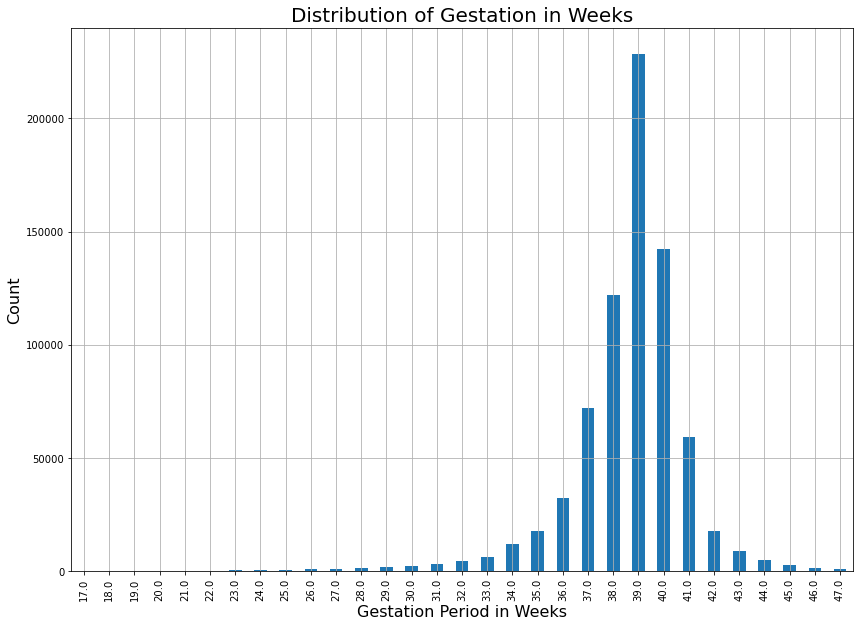

In [90]:
fig, ax = plt.subplots(figsize=(14,10))
X['combgest'].value_counts().sort_index().plot(kind='bar', ax = ax)
ax.set_ylabel('Count', fontsize=16)
ax.set_xlabel('Gestation Period in Weeks', fontsize=16)
ax.set_title('Distribution of Gestation in Weeks', fontsize=20)

ax.grid(b=True, which='major')
fig.savefig('GestDist',bbox_inches = 'tight', pad_inches=0.5)

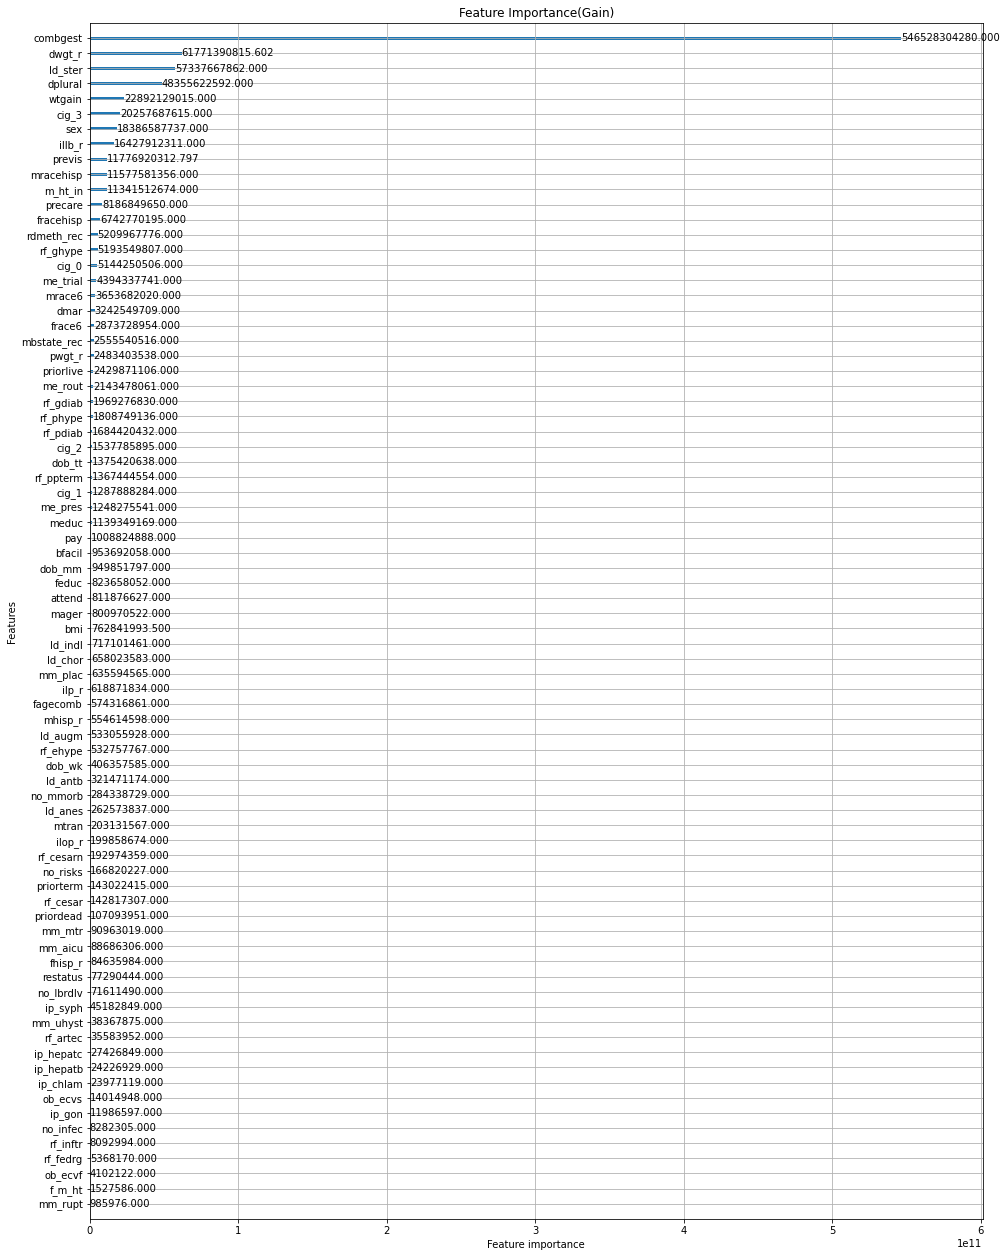

In [30]:
fig, ax = plt.subplots(figsize=(16,22))
lgb.plot_importance(m_lgb, importance_type='gain', ax= ax, title='Feature Importance(Gain)')
fig.savefig('FeatureImportanceGain', bbox_inches = 'tight', pad_inches=0.5)

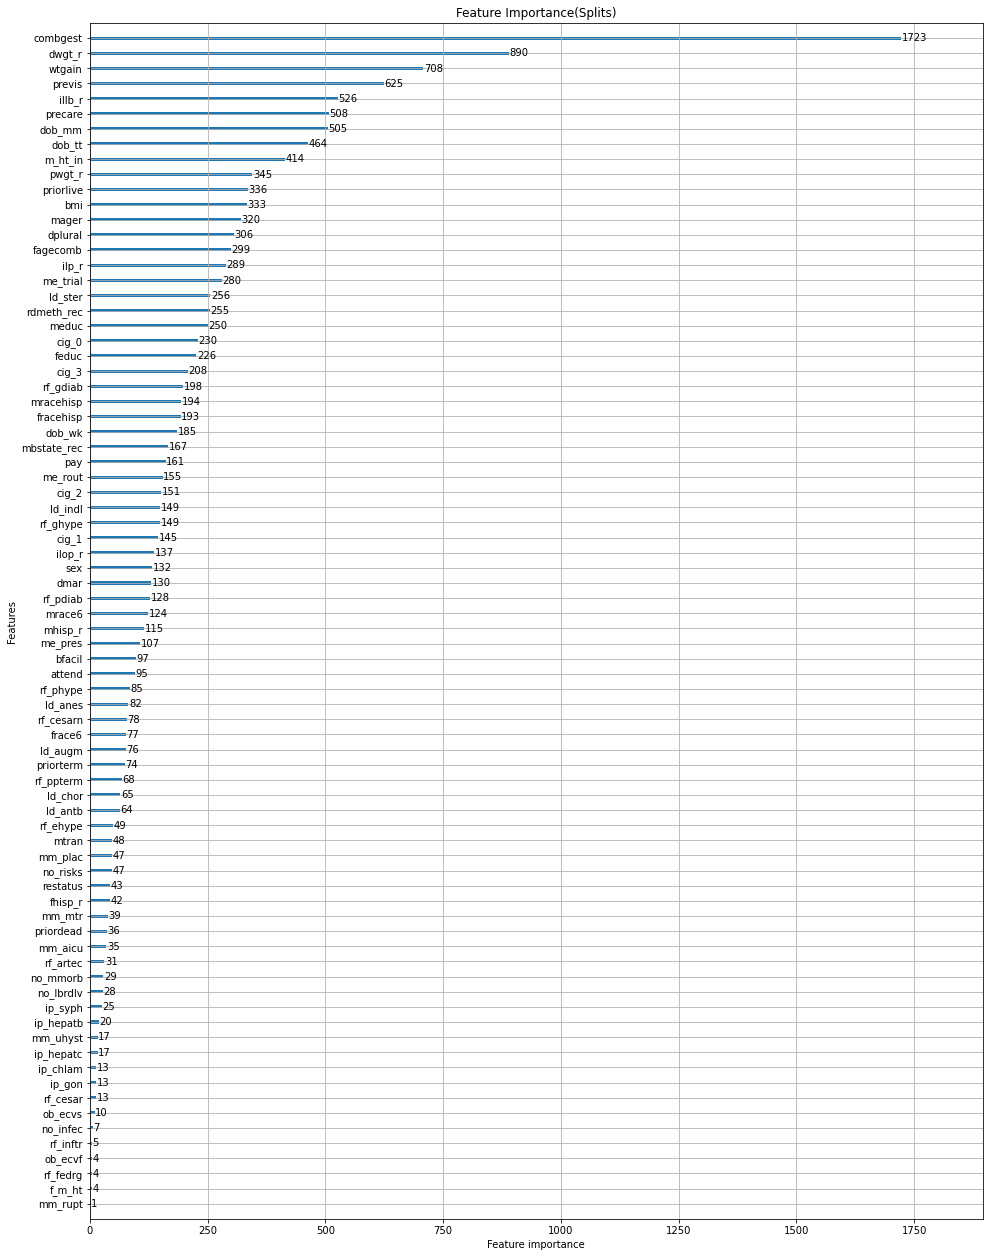

In [31]:
fig, ax = plt.subplots(figsize=(16,22))
lgb.plot_importance(m_lgb, importance_type='split',title='Feature Importance(Splits)', ax= ax)
fig.savefig('FeatureImportanceSplits', bbox_inches = 'tight', pad_inches=0.5)

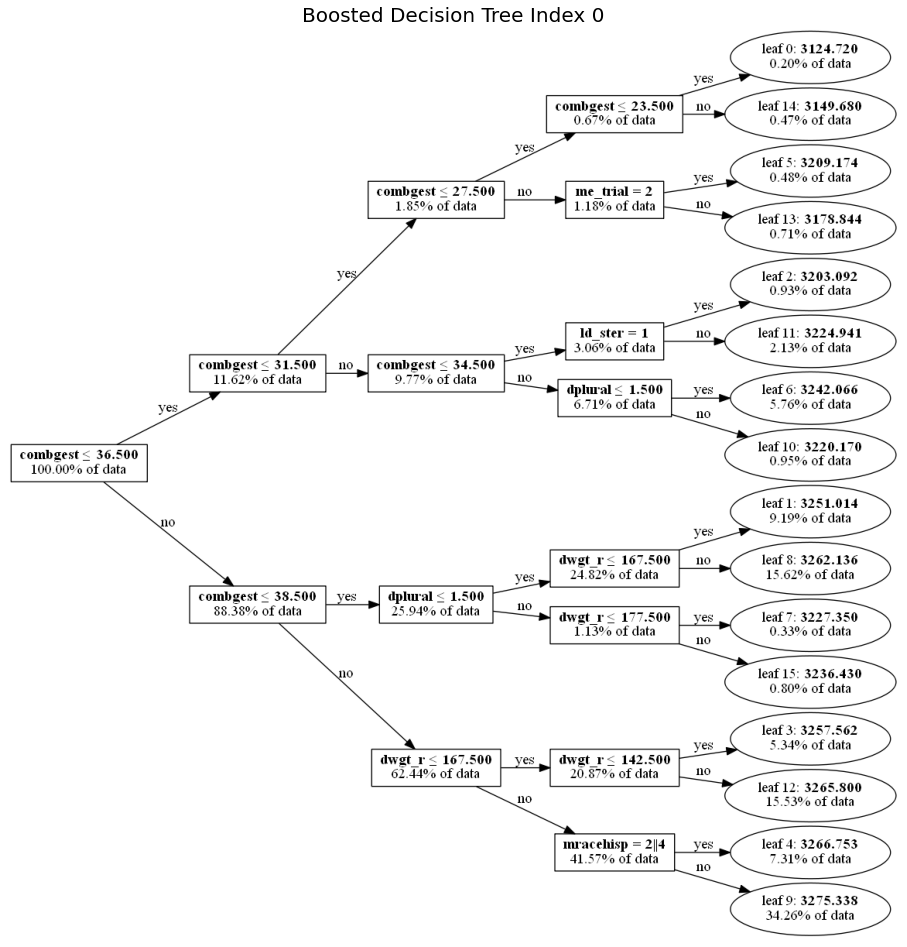

In [79]:
fig, ax = plt.subplots(figsize=(16,22))
lgb.plot_tree(m_lgb, show_info='data_percentage', ax= ax, tree_index=0)
ax.set_title('Boosted Decision Tree Index 0', fontsize=20)
fig.savefig('gbdt0', bbox_inches = 'tight', pad_inches=0.5);

Text(0.5, 1.0, 'Boosted Decision Tree Index 1')

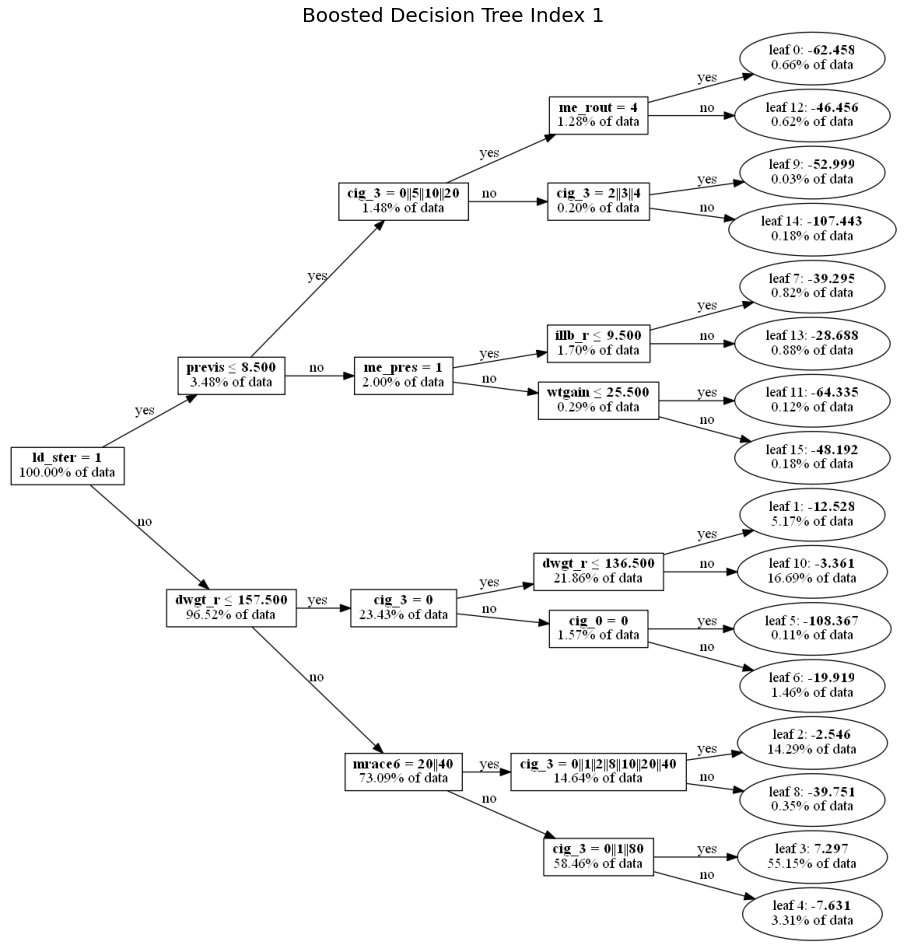

In [75]:
fig, ax = plt.subplots(figsize=(16,22))
lgb.plot_tree(m_lgb, show_info='data_percentage', ax= ax, tree_index=1)
ax.set_title('Boosted Decision Tree Index 1', fontsize=20)

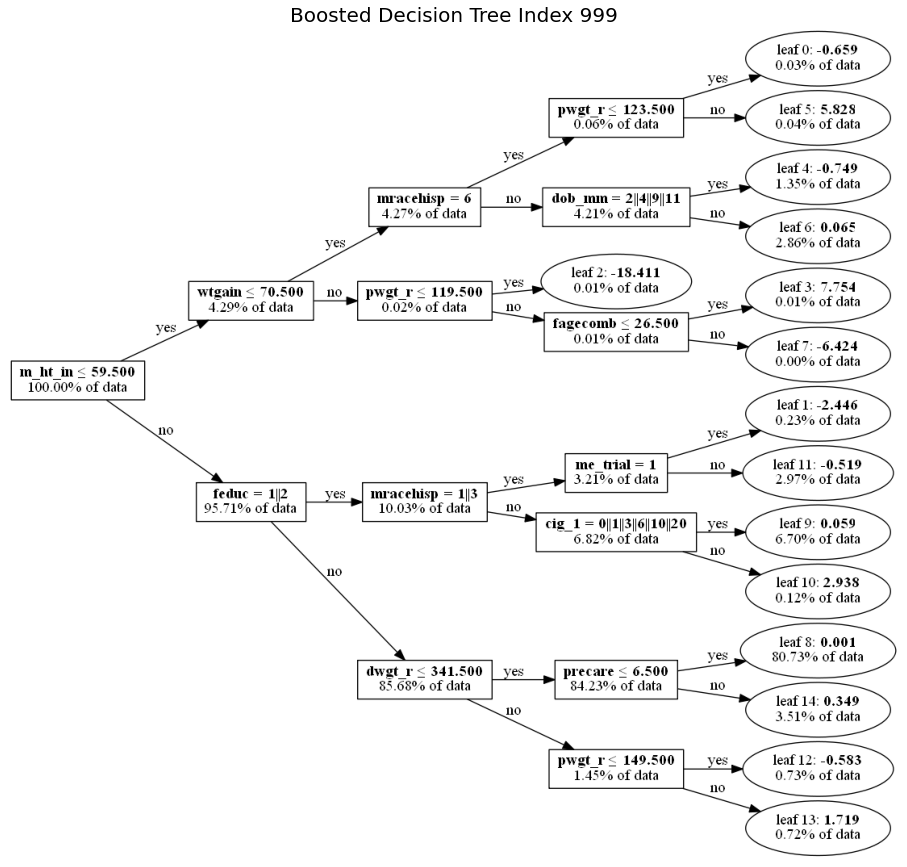

In [80]:
fig, ax = plt.subplots(figsize=(16,22))
lgb.plot_tree(m_lgb, show_info='data_percentage', ax= ax, tree_index=999)
ax.set_title('Boosted Decision Tree Index 999', fontsize=20)
fig.savefig('gbdt999', bbox_inches = 'tight', pad_inches=0.5)